# COGS 108 - EDA Checkpoint

# Names

- Tong Zeng
- Kaiyu Guan
- Will Sumerfield
- Janty Sphabmixay

<a id='research_question'></a>
# Research Question

To what degree can we predict the crime rates in the counties of San Diego using data including population density, weather, temperature, income, and the number of police stations in these areas?

# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import math

# Data Cleaning

We first download the five datasets from the websites respectively.
Then we retrieve columns that contain our desired variables, rename those columns to be more comprehensive,
and check for null values.

When merging the datasets, we will merge each independent variables(weather, income, police, population density) with the dependent varibele(crime) on county and year. <B>I don't know how the crime dataset looks like at this moment so we would have to come back for this part.<b/>

## Police

In [3]:
#Read the police datasets from 2010 to 2019
police2010 = pd.read_csv('Datasets/Police Per County/Police Per County 2010.csv')
police2011 = pd.read_csv('Datasets/Police Per County/Police Per County 2011.csv')
police2012 = pd.read_csv('Datasets/Police Per County/Police Per County 2012.csv')
police2013 = pd.read_csv('Datasets/Police Per County/Police Per County 2013.csv')
police2014 = pd.read_csv('Datasets/Police Per County/Police Per County 2014.csv')
police2015 = pd.read_csv('Datasets/Police Per County/Police Per County 2015.csv')
police2016 = pd.read_csv('Datasets/Police Per County/Police Per County 2016.csv')
police2017 = pd.read_csv('Datasets/Police Per County/Police Per County 2017.csv')
police2018 = pd.read_csv('Datasets/Police Per County/Police Per County 2018.csv')
police2019 = pd.read_csv('Datasets/Police Per County/Police Per County 2019.csv')
police2010.head(10)

,Table 80,,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,CALIFORNIA,NaN,NaN,NaN,NaN
1,Full-time Law Enforcement Employees,NaN,NaN,NaN,NaN
2,"by Metropolitan and Nonmetropolitan Counties, ...",NaN,NaN,NaN,NaN
3,Metropolitan/Nonmetropolitan,County,Total law\nenforcement\nemployees,Total\nofficers,Total\ncivilians
4,Metropolitan Counties,Alameda,"1,635",986,649
5,NaN,Butte,258,101,157
6,NaN,Contra Costa,952,637,315
7,NaN,El Dorado,346,173,173
8,NaN,Fresno,891,693,198
9,NaN,Imperial,271,180,91


We found that since all the dataframe of police are download from the same website and are in same format, we decided to define a function that clean all the 10 dataframes.

In [4]:
def to_int(string):
    return int(string.replace(',', ''))

def clean(df):
    #Found the year of the dataframe
    year = df[df.columns[0]].iloc[2][-4:]
    #For every dataframe, drop the first 4 rows which contains unwanted information
    df = df.drop(df.index[[0, 1, 2, 3]])
    #Retrive colomns with useful information
    df = df.iloc[: , 1:5]
    #Reindex the dataset
    df = df.reset_index(drop = True)
    #Rename the columns
    df = df.rename(columns={df.columns[0]: 'County', df.columns[1]: 'Total_Officers', df.columns[2] : 'Officers', df.columns[3] : 'Civilian_Officers'})
    #Extract wanted columns from the dataset
    df = df[['County', 'Total_Officers']]
    #Add a colomn of year and convert all the values in columns of Total_officers to integer
    df = df.assign(
        Year = np.repeat(int(year), df.shape[0]),
        Total_Officers = df['Total_Officers'].apply(to_int)
    )
    return df

In [5]:
#apply the defined function to all the DataFrame
police_2010 = clean(police2010)
police_2011 = clean(police2011)
police_2012 = clean(police2012)
police_2013 = clean(police2013)
police_2014 = clean(police2014)
police_2015 = clean(police2015)
police_2016 = clean(police2016)
police_2017 = clean(police2017)
police_2018 = clean(police2018)
police_2019 = clean(police2019)
police_2010.head()

,County,Total_Officers,Year
0,Alameda,1635,2010
1,Butte,258,2010
2,Contra Costa,952,2010
3,El Dorado,346,2010
4,Fresno,891,2010


After cleaning all the dataset seperatedly, we now append these dataset from each year into a large DataFrame and check for null values.

In [6]:
frames = [police_2010, police_2011, police_2012, police_2013, police_2014, police_2015, police_2016, police_2017, police_2018, police_2019]
police = pd.concat(frames).reset_index(drop = True)
police['County'] = police['County'].str.lower()
police.head()

,County,Total_Officers,Year
0,alameda,1635,2010
1,butte,258,2010
2,contra costa,952,2010
3,el dorado,346,2010
4,fresno,891,2010


In [7]:
#check for null values
police.isnull().values.any()

False

The police data is now clean and ready to use.

## Income

In [7]:
# Collect all Income csv files
income_files = glob.glob("Datasets/Income Per Capita/*.csv")

# Create a list of dataframes
li = [None] * 10

# Add each file separately, to account for differences
for i in range(len(income_files)):
    li[i] = pd.read_csv(income_files[i], index_col=None, header=1)
    if i < 8:
        li[i] = li[i][["Geographic Area Name",
                       "Mean income (dollars)!!Estimate!!PER CAPITA INCOME BY RACE AND HISPANIC OR LATINO ORIGIN!!Total population"]]
    else:
        li[i] = li[i][["Geographic Area Name",
                       "Estimate!!Mean income (dollars)!!PER CAPITA INCOME BY RACE AND HISPANIC OR LATINO ORIGIN!!Total population"]]

    # Rename the columns to be more readable
    li[i].columns = ["County", "Mean Income Per Capita"]

# Concatenate the dataframes together
income = pd.concat(li, axis=0, ignore_index=True)

# Add the year column
income["Year"] = [2010 + math.floor((i+1) / 40) for i in range(income.shape[0])]

# Remove " County, California" from county names
income["County"] = income["County"].str.replace(" County, California", "")

# Make county names lowercase
income["County"] = income["County"].str.lower()

# Drop null values
income = income.dropna()
income = income[income["Mean Income Per Capita"] != "N"]

# Change the Mean Income column into an integer type
income = income.astype({'Mean Income Per Capita': 'int32'})

# Reindex the rows
income = income.reset_index(drop=True)

## Population Density
To calculate population density, we needed to use a dataset for Population per County,
and a dataset containing the Square Miles per County.

### Square Miles per County Cleaning
First, we needed to clean the Square Miles per County Dataset.

In [8]:
# Open the Square Miles File
file = open("Datasets/Population Density People Per Square Mile/Square Miles Per County.csv", "r")

# Get all lines in a file
lines = file.readlines()

# For every line in the file...
for i in range(len(lines)):

    # Get the current line type
    line_type = i % 3

    # If this is the county line
    if line_type == 0:
        lines[i] = lines[i].replace(" County", "")
        lines[i] = lines[i].replace("\n", ",")
        lines[i] = lines[i].lower()

    # If this is the number line
    elif line_type == 1:
        lines[i] = lines[i].replace(",", "")

    # If this is the empty line
    elif line_type == 2:
        lines[i] = ""

# Remove any old copy of this file
if os.path.isfile("Datasets/Population Density People Per Square Mile/Square Miles Per County Cleaned.csv"):
    os.remove("Datasets/Population Density People Per Square Mile/Square Miles Per County Cleaned.csv")

# Open the new file
new_file = open("Datasets/Population Density People Per Square Mile/Square Miles Per County Cleaned.csv", "a")

# Write a header
new_file.write("County,Square Miles\n")

# Write in the cleaned lines
for line in lines: new_file.write(line)

# Close the file
new_file.close()

# Read the Square Miles per County File
sq_county = pd.read_csv('Datasets/Population Density People Per Square Mile/Square Miles Per County Cleaned.csv')

# Change the Square Miles column into an integer type
sq_county = sq_county.astype({'Square Miles': 'int32'})
sq_county.head()

,County,Square Miles
0,san bernardino,20057
1,inyo,10181
2,kern,8132
3,riverside,7206
4,siskiyou,6278


### Population per County Cleaning
Next, we needed to clean the data which gave us the population in each county.

In [9]:
# Read the Population Dataset
population = pd.read_csv('Datasets/Population Density People Per Square Mile/Population Per Year.csv')

# Drop the first "Geo-ID" column
population = population.drop("GEO_ID", axis=1)

# Rename the columns to the real names
population = population.rename(columns=population.iloc[0, :])

# Remove the old columns row
population = population.iloc[1:, :]

# Rename the columns
population.columns = ['County', 'Year', 'Population']

# Remove ' County, California'
population["County"] = population["County"].str.replace(" County, California", "")
population["County"] = population["County"].str.lower()

# Remove rows which contain irrelevant information
population = population[~population["Year"].isin(["4/1/2010 Census population", "4/1/2010 population estimates base"])]

# Remove text, months, and days from the years column
population["Year"] = population["Year"].str[4:8]

# Reindex the dataset
population = population.reset_index(drop=True)

# Change the second column into an integer type
population = population.astype({'Population': 'int64'})
population.head()

,County,Year,Population
0,alameda,2010,1512986
1,alameda,2011,1530915
2,alameda,2012,1553764
3,alameda,2013,1579593
4,alameda,2014,1607792


### Population Density Calculation
Finally, we needed to calculate population density using Population per County, and Square Miles per County.

In [10]:
# Create the population density dataframe
population_density = population.rename({'Population': 'Population Density'}, axis=1)

# Do the math for population density
for i in range(population.shape[0]):

    # Get the county at the current row
    county = population.iat[i, 0]

    # Set the population density
    population_density.iat[i, 2] = population.iat[i, 2] / sq_county.loc[
        sq_county['County'] == county]["Square Miles"].values[0]

# Drop null values
population_density = population_density.dropna()
population_density.head()

,County,Year,Population Density
0,alameda,2010,2047
1,alameda,2011,2071
2,alameda,2012,2102
3,alameda,2013,2137
4,alameda,2014,2175


## Weather

The weather dataset has two variables: temperature and precipitation. The two variables are downlaoded separately but merged together to use.

In [11]:
#import precipitation dataset and temperature dataset
precip = pd.read_csv('Datasets/Weather/precip.csv')
temp = pd.read_csv('Datasets/Weather/temp.csv')

#Retrive columns with useful information
temp = temp[['Location', 'Date', 'Value']]
precip = precip[['Location', 'Date', 'Value']]

#Rename columns
temp.columns = ['County', 'Month', 'Avg_Temperature']
precip.columns = ['County', 'Month', 'Avg_Precipitation']

#Merge the two datasets
weather = temp.merge(precip)

In [12]:
#Check for null values
weather.isnull().values.any()

False

After cleaning and merging the data, we would now need to reformat the values in our dataset to be consistent with other datasets.

In [13]:
#Returns the month of the str
def find_year(date):
    return int(date/100)

#Returns the county name without 'county'
def county(str):
    return str.replace('County', '').lower().strip()

#Apply the function to find the year and remove 'county' from county names
weather['Year'] = weather['Month'].apply(find_year)
weather['County'] = weather['County'].apply(county)

#Group the dataset by Year and County to find the yearly mean values
weather = weather.drop(columns = 'Month').groupby(['Year', 'County']).mean().reset_index()

#Retrive data from 2010 to 2019
weather = weather[(weather['Year']>=2010)&(weather['Year']<=2019)].reset_index(drop = True)
weather.head()

,Year,County,Avg_Temperature,Avg_Precipitation
0,2010,alameda,58.283333,1.930833
1,2010,alpine,42.900000,4.124167
2,2010,amador,56.608333,4.339167
3,2010,butte,58.575000,4.825000
4,2010,calaveras,57.041667,4.228333


## Crime

In [14]:
# Import the Crime Dataset
crime = pd.read_csv("Datasets/Crimes Per County/Crimes_and_Clearances.csv")

# Retriving Data containing Years 2010-2019 
crime = crime[(crime['Year'] >= 2010) & (crime['Year'] <= 2019)]

# Lower Case the County Names
crime['County'] = crime['County'].str.lower()

# Stripping 'County' from County Names
def county(county_name):
    return county_name.replace('county', '').strip()

# Returns the Stripped County Names
crime['County'] = crime['County'].apply(county)

# Sum Crime Columns
crime_sum = crime['Violent_sum'] + crime['Homicide_sum'] + crime['ForRape_sum'] + crime['Robbery_sum'] + crime['AggAssault_sum'] + crime['Property_sum'] + crime['Burglary_sum'] +  crime['VehicleTheft_sum'] + crime['LTtotal_sum']
crime['Sum of Crimes'] = crime_sum

# Drop
crime = crime.drop(columns=['NCICCode', 'Violent_sum', 'Homicide_sum', 'ForRape_sum',
                            'Robbery_sum', 'AggAssault_sum','Property_sum', 'Burglary_sum',
                            'VehicleTheft_sum', 'LTtotal_sum', 'ViolentClr_sum', 'HomicideClr_sum',
                            'ForRapeClr_sum', 'RobberyClr_sum', 'AggAssaultClr_sum', 'PropertyClr_sum',
                            'BurglaryClr_sum', 'VehicleTheftClr_sum', 'LTtotalClr_sum', 'TotalStructural_sum',
                            'TotalMobile_sum', 'TotalOther_sum', 'GrandTotal_sum', 'GrandTotClr_sum',
                            'RAPact_sum', 'ARAPact_sum', 'FROBact_sum', 'KROBact_sum', 'OROBact_sum',
                            'SROBact_sum', 'HROBnao_sum', 'CHROBnao_sum', 'GROBnao_sum', 'CROBnao_sum',
                            'RROBnao_sum', 'BROBnao_sum', 'MROBnao_sum', 'FASSact_sum', 'KASSact_sum', 
                            'OASSact_sum', 'HASSact_sum', 'FEBURact_Sum', 'UBURact_sum', 'RESDBUR_sum',
                            'RNBURnao_sum', 'RDBURnao_sum', 'RUBURnao_sum', 'NRESBUR_sum', 'NNBURnao_sum',
                            'NDBURnao_sum', 'NUBURnao_sum', 'MVTact_sum', 'TMVTact_sum', 'OMVTact_sum',
                            'PPLARnao_sum', 'PSLARnao_sum', 'PSLARnao_sum', 'SLLARnao_sum', 'MVLARnao_sum',
                            'MVPLARnao_sum', 'BILARnao_sum', 'FBLARnao_sum', 'COMLARnao_sum', 'AOLARnao_sum',
                            'LT400nao_sum', 'LT200400nao_sum', 'LT50200nao_sum', 'LT50nao_sum'])

# Print Arrests Dataset
crime = crime.groupby(['Year', 'County']).sum().reset_index()
crime.head()

/Users/kaiyuguan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Year,County,Sum of Crimes
0,2010,alameda,121582
1,2010,alpine,174
2,2010,amador,1900
3,2010,butte,13404
4,2010,calaveras,1836


In [15]:
#Check for null values
crime.isnull().values.any()

False

# Data Analysis & Results (EDA)

**Note:**

Because our data is both over time and per county, this makes it quite hard to graph in a way
is visually discernible. If we graph showing the change over time for each county, there are too
many county to differentiate - it is too cluttered. If we graph using frequency of values, we
ignore change over time and county as a factor. Our solution is to graph both using frequency
of values, and a graph of the change of the sum over time (for applicable datasets). Ideally,
we would show you graphs of change for all 58 counties over time. However, this is not feasible.

## Police Dataset Exploratory Data Analysis and Visualization

First, since the police dataset refers to the number of police officers per county per year, we do not expect to see any clear trend in our distribution. However, it is useful to visualize the general trend of the total police officers in the time range that our data is collected. To do this, we would generate a lineplot with years on the x axis. 

In [16]:
police_sum = police.groupby('Year').sum()
police_sum.head()

,Total_Officers
Year,
2010,50929
2011,50846
2012,51384
2013,52115
2014,52668


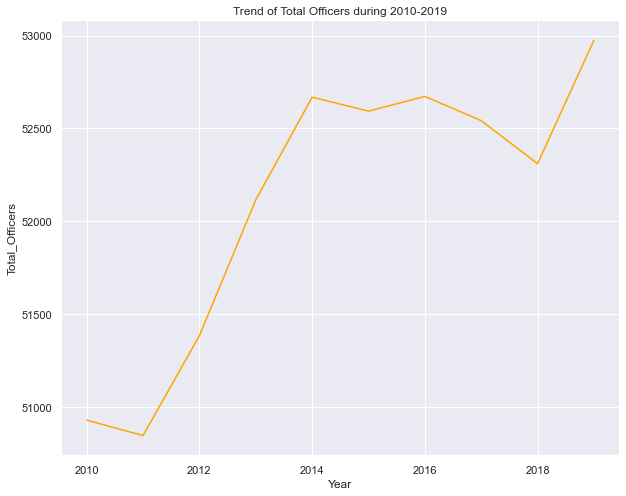

In [17]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data = police_sum, x = 'Year', y = 'Total_Officers', color = 'orange').set(title = 'Trend of Total Officers during 2010-2019')
plt.show()

Here we can see that generally the totall number of police officers in California increased from 2010 to 2019 with a slight drop in 2011 and 2018 but continued to increase afterwards.  
Then we chose to plot out the distribution of the number of police in all counties throughout these 10 years. As shown, the y-axis shows the number of time a range of number of police appears in the dataset and the x-axis shows the range.

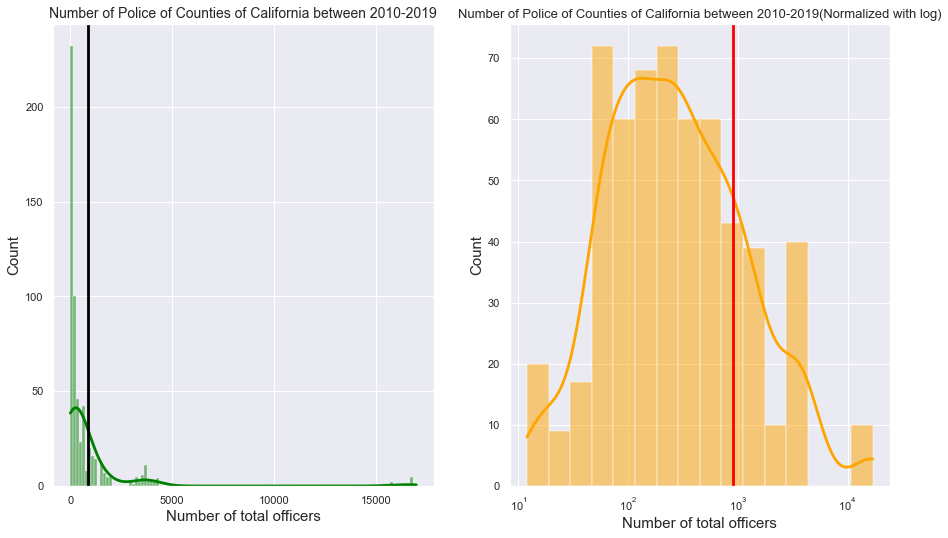

In [18]:
sns.set(rc={'figure.figsize':(15,8.5)})
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.style.use('seaborn-poster')

sns.histplot(data=police, x='Total_Officers', ax=ax1, kde=True, color='green')
ax1.set_xlabel('Number of total officers', fontsize = 15)
ax1.set_ylabel('Count', fontsize = 15)
ax1.set_title('Number of Police of Counties of California between 2010-2019', fontsize = 14)
ax1.axvline(x = police.Total_Officers.mean(), color = 'black')

sns.histplot(data=police, x='Total_Officers', ax=ax2, kde=True, color='orange', log_scale=True)
ax2.set_xlabel('Number of total officers', fontsize = 15)
ax2.set_ylabel('Count', fontsize = 15)
ax2.set_title('Number of Police of Counties of California between 2010-2019(Normalized with log)', fontsize = 13)
ax2.axvline(x = police.Total_Officers.mean(), color = 'red')
plt.show()

As shown in the right plot, the number of police in all counties of California in these
10 years have a right skew distribution. When we convert the plot to the log-scale version,
the distribution of the data is now roughly normal, with a mean around 1000 police.

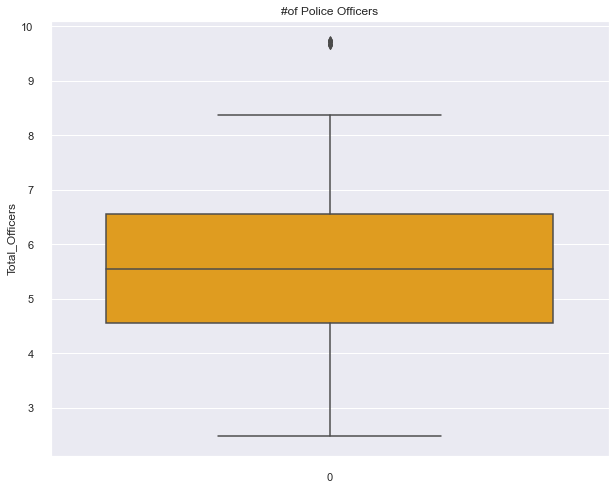

In [19]:
sns.set(rc={'figure.figsize':(10,8)})
#draw boxplot to visualize outliers
sns.boxplot(data=np.log(police['Total_Officers']), color = 'orange').set(title='#of Police Officers', ylabel='Total_Officers')
plt.show()

In [20]:
#To check for outliers and see how many data is in the right most bin 
police[police['Total_Officers'] > 10000].shape[0]

10

Since our dataset contains the information of 10 years, it is reasonable to assume this 10 data result from 1 county that has more police than other counties. Because of this, we would not consider these 10 data as outliers and will incorporate them in the following analysis.

## Income Dataset Exploratory Data Analysis and Visualization

For the Income data, we chose to plot the frequency of all incomes across all counties, first.

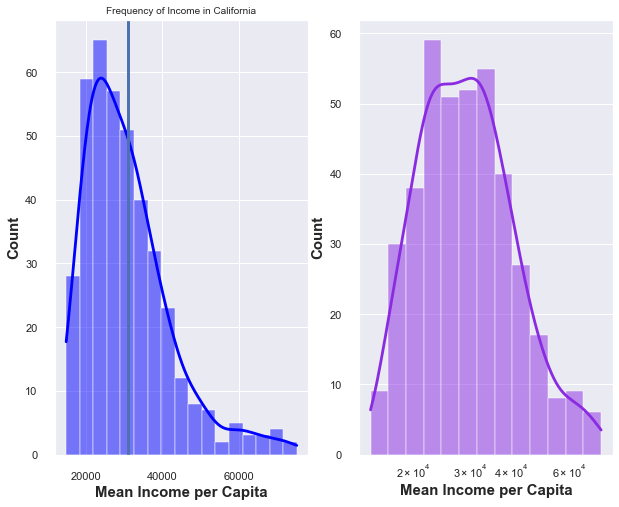

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.style.use('seaborn-poster')

sns.histplot(data=income, x='Mean Income Per Capita', ax=ax1, kde=True, color='blue')
ax1.set_xlabel('Mean Income per Capita', fontsize = 15, weight = 'bold')
ax1.set_ylabel('Count', fontsize = 15, weight = 'bold')
ax1.set_title('Frequency of Income in California', fontsize = 10)
ax1.axvline(x = income["Mean Income Per Capita"].mean())

sns.histplot(data=income, x='Mean Income Per Capita', ax=ax2, kde=True, color='blueviolet', log_scale=True)
ax2.set_xlabel('Mean Income per Capita', fontsize = 15, weight = 'bold')
ax2.set_ylabel('Count', fontsize = 15, weight = 'bold')
ax1.axvline(x = income["Mean Income Per Capita"].mean())


The figures above show us that our income is generally right skewed. Using a log scale,
however, shows us that it is roughly normally distributed. There are not any significant outliers,
the highest average per county being somewhere around 80,000 per year, per capita. The average
mean income is around 30,000 per year.

Next, we want to graph the sum of the incomes over time, to visualize how income has
changed over the 10 years we are observing.

Text(0.5, 1.0, 'Yearly Income Trend')

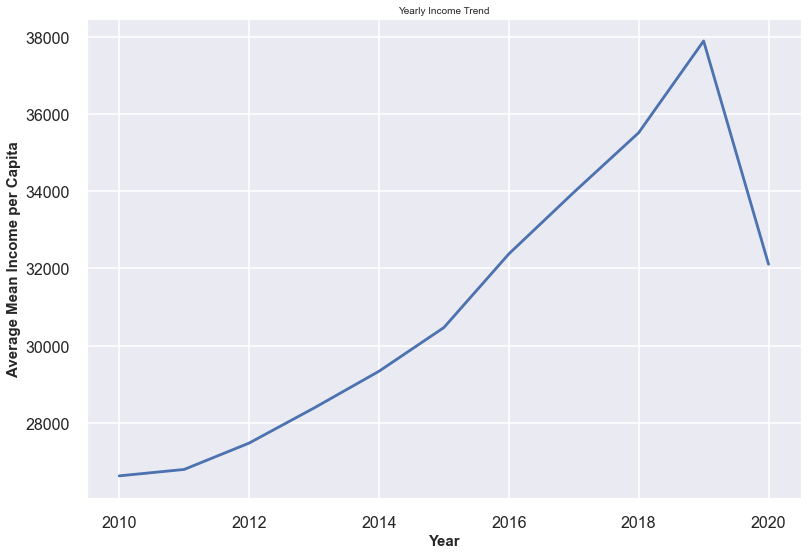

In [22]:
income_sum = income.copy()
income_sum["Mean Income Per Capita"] = income.groupby(["Year"])["Mean Income Per Capita"].transform(np.mean)

p = sns.lineplot(data=income_sum, x='Year', y="Mean Income Per Capita")
p.set_xlabel('Year', fontsize = 15, weight = 'bold')
p.set_ylabel('Average Mean Income per Capita', fontsize = 15, weight = 'bold')
p.set_title('Yearly Income Trend', fontsize = 10)

This graph shows us that over time, the average inflation-adjusted income in California has been
steadily increasing. However, around 2019 (COVID-Era) that mean income sharply dropped.

To get a better picture, we can look at a botplot of the income. Here, we see more clearly that the average income
is slighly below 30,000, which is skewed towards lower incomes. We can also see that there are no significant outliers, unless you count the one point around 77,000.

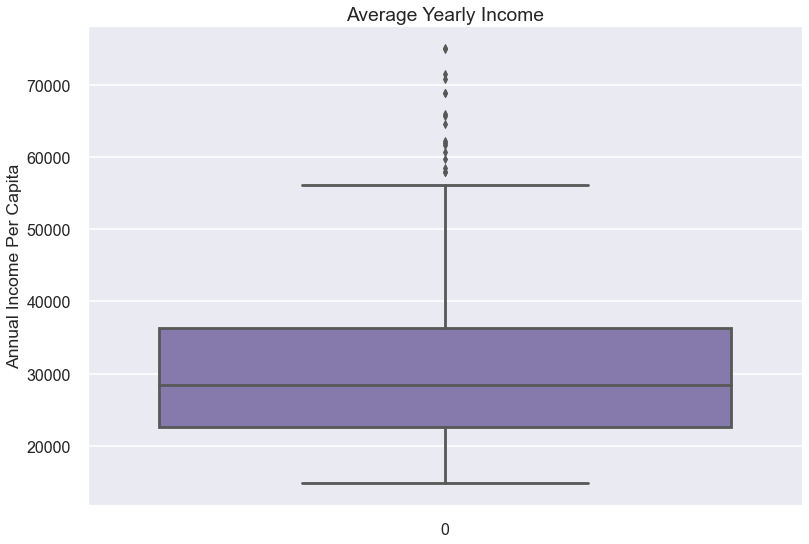

In [23]:
# Plot the Income's boxplot
sns.boxplot(data=income['Mean Income Per Capita'], color = 'm').set(title='Average Yearly Income', ylabel='Annual Income Per Capita')
plt.show()

## Weather Exploratory Data Analysis and Visualization

Since our weather dataset collects data from all 58 counties in california which are geospatially close in consecutive 10 years, we expect that the overall distribution of our data would show a normal trend. 

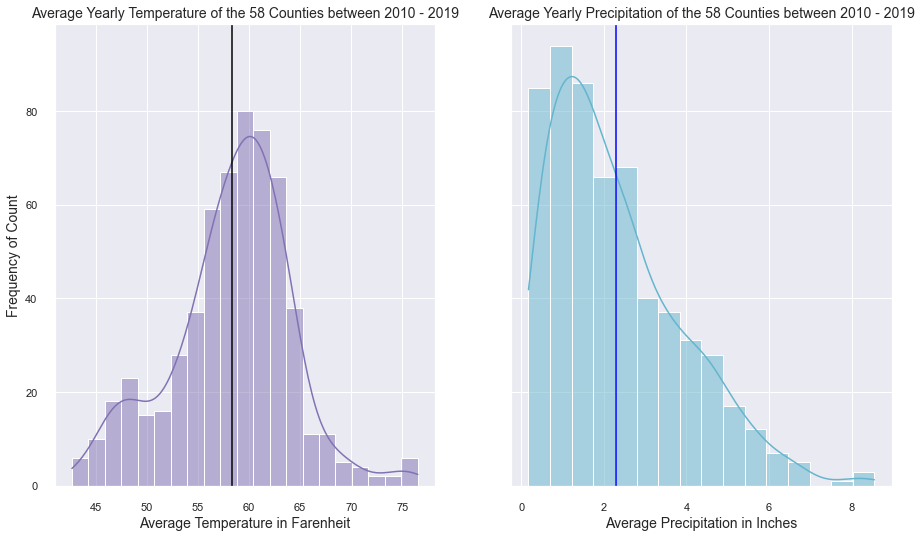

In [24]:
#plot the histograms of temperature
sns.set(rc={'figure.figsize':(15,8.5)})
fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True)
sns.histplot(data = weather['Avg_Temperature'], ax = ax1, kde = True, color = 'm')
ax1.set_xlabel('Average Temperature in Farenheit', size = 14)
ax1.set_title('Average Yearly Temperature of the 58 Counties between 2010 - 2019', size = 14)
ax1.set_ylabel('Frequency of Count', size = 14)
ax1.axvline(x = weather.Avg_Temperature.mean(), color = 'black')
##plot the histograms of precipitation
sns.histplot(data = weather['Avg_Precipitation'], ax = ax2, kde = True, color = 'c')
ax2.set_xlabel('Average Precipitation in Inches', size = 14)
ax2.set_title('Average Yearly Precipitation of the 58 Counties between 2010 - 2019', size = 14)
ax2.axvline(x = weather.Avg_Precipitation.mean(), color = 'Blue')
plt.show()

In the above graphs, we define frequency as the count of temperature/precipitaion of the 58 counties during 2010 to 2019. In other words, a frequency of 60 for 56 Farenheit means that of all the 58 counties over the ten years, there were 60 times that a county's yearly average temperature was recorded as 56 Farenheit. Same definition of frequency applies to the precipiation graph.  
According to the above histograms, the distribution of yearly average temperature is almost Gaussian with a best fitted line of a bell-shaped curve. The mean value of this distribution is around 58 Farenheit with mode of 60. Unlike temperature, the distribution of yearly average precipitaion is mostly centered around 0-2 inches(No precipitation to light rainfall) with a highly skew to 6-8 inches(heavy rainfall). The mean of the distrbution is around 2.5 and the mode is around 1. For both distribution, there are a few outliers, we will visualize these values to get a better sense of our data. However, concerning the number of data we have, we will not remove those outliers but are aware of these values.

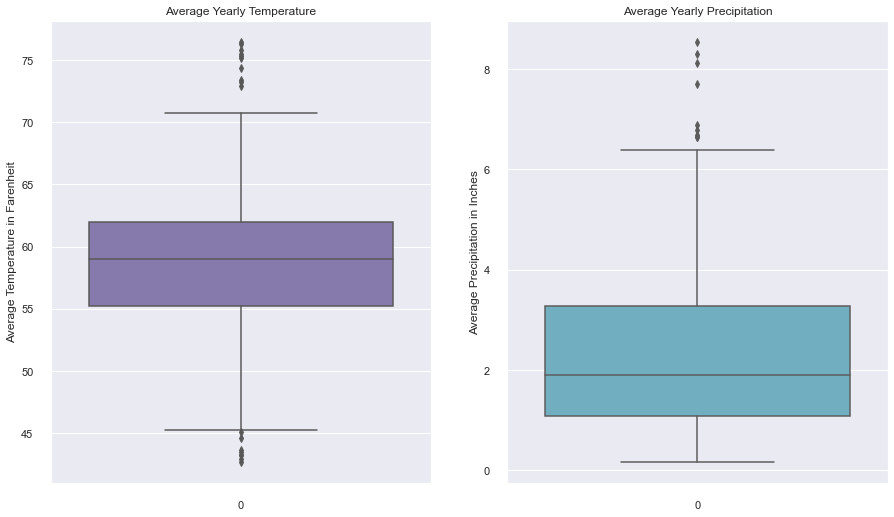

In [25]:
#plot the boxplot of temperature and precipitation to get a sense of the IQR and outliers
fig, (ax3, ax4) = plt.subplots(ncols = 2, sharey = False)
sns.boxplot(data=weather['Avg_Temperature'], ax = ax3, color = 'm').set(title='Average Yearly Temperature', ylabel='Average Temperature in Farenheit')
sns.boxplot(data=weather['Avg_Precipitation'], ax = ax4, color = 'c').set(title='Average Yearly Precipitation', ylabel='Average Precipitation in Inches')
plt.show()

The temperature distribution have outliers ranges from 45 to lower and 72 to higher while the percipitation distribution have outliers from 7.5 to highers. We will then look at the descriptive statistics of our temperature and precipitation dataset over the ten years.

In [26]:
#find the descriptive statistics of temperature across ten years
temp_stat = pd.DataFrame()
for i in range(2010, 2020):
    temp_stat[i] = weather[weather['Year'] == i]['Avg_Temperature'].describe()
temp_stat

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,56.521983,56.193822,58.034483,58.162644,60.316379,59.733621,58.885201,59.055891,58.769540,57.589224
std,5.764261,5.816219,5.788712,5.764682,5.733938,5.579523,5.793114,6.011645,5.788278,5.855798
min,42.900000,42.691667,45.100000,44.600000,46.800000,46.350000,45.900000,45.400000,45.716667,43.466667
25%,53.806250,53.370833,55.337500,55.664583,57.652083,56.718750,55.931250,56.175000,56.000000,54.608333
50%,57.104167,57.070833,58.795833,59.137500,61.075000,60.670833,59.658333,60.066667,59.766667,58.562500
75%,60.237500,59.925000,61.845833,61.908333,63.887500,63.054167,62.456250,62.822917,62.462500,61.462500
max,73.408333,73.283333,75.216667,74.358333,76.508333,75.858333,75.508333,76.333333,75.333333,72.916667


In [27]:
#find the descriptive statistics of precipitation across ten years
precip_stat = pd.DataFrame()
for i in range(2010, 2020):
    precip_stat[i] = weather[weather['Year'] == i]['Avg_Precipitation'].describe()
precip_stat

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,3.193132,2.004511,2.593218,0.739670,2.176681,1.465876,2.736264,3.118922,1.944210,3.040431
std,1.652230,1.114256,1.732823,0.474884,1.298571,1.058308,1.736522,1.883263,1.035203,1.533325
min,0.530833,0.210833,0.206667,0.197500,0.171667,0.184167,0.255000,0.235000,0.172500,0.313333
25%,2.036042,1.235625,1.214167,0.414792,1.172500,0.731042,1.478958,1.741250,1.196875,1.920833
50%,2.769167,1.681250,2.120000,0.556667,1.819167,1.164583,2.065417,2.513750,1.590000,2.632500
75%,4.311458,2.788958,3.744583,1.013125,3.245000,2.111250,3.972917,4.541250,2.828750,4.271042
max,8.293333,5.612500,8.551667,2.916667,5.596667,5.779167,8.132500,7.713333,4.538333,6.637500


By looking at the statistics of both distributions, here we can see that over the ten years, the mean of temperature dataset is always close to the median implying that the distribution of temperature in the ten years are always normal, moreover, based on the statistics, the temperature was almost steady in evey aspect across the ten years while precipitation fluctuate more. Also, it should be pointed out the outliers(>6.5) in the preciptation dataset happened in 2010, 2012, 2016 and 2019.  
Knowing that yearly overall trend of the distribution of temperature and precipitation, let's continue to explore the data by visualizing the top 5 counties for temperature and preciptation separately. 

In [28]:
weather.groupby('County').mean().sort_values('Avg_Temperature', ascending = False).head(5)

,Year,Avg_Temperature,Avg_Precipitation
County,,,
imperial,2014.5,74.872500,0.258000
riverside,2014.5,69.310000,0.636917
san bernardino,2014.5,67.411667,0.539083
orange,2014.5,65.165833,0.954667
kings,2014.5,64.780833,0.584833


In [29]:
weather.groupby('County').mean().sort_values('Avg_Precipitation', ascending = False).head(5)

,Year,Avg_Temperature,Avg_Precipitation
County,,,
del norte,2014.5,52.782500,6.377167
humboldt,2014.5,54.806667,5.084750
trinity,2014.5,53.430833,4.640750
nevada,2014.5,53.055000,4.421417
mendocino,2014.5,56.184167,4.251167


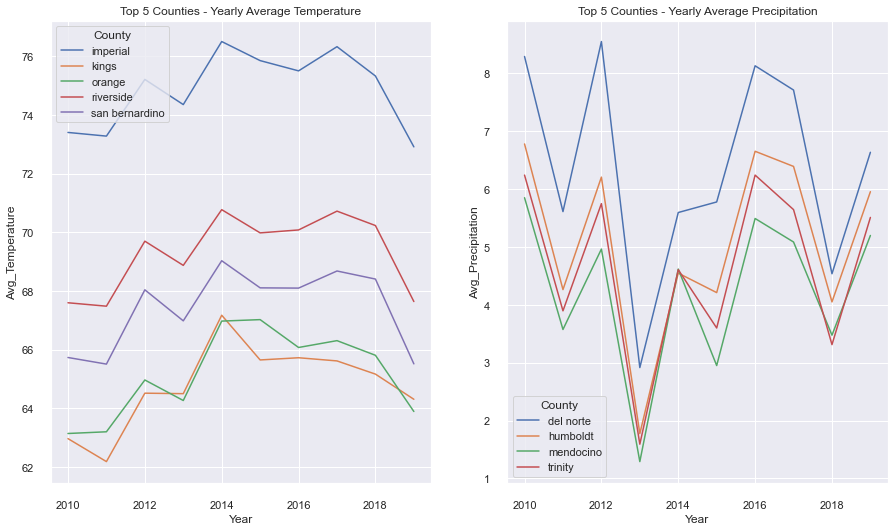

In [30]:
#Generating line plots for temperature and precipitation
topfivetemp = ['imperial', 'riverside', 'san bernardino', 'orange', 'kings']
topfiveprecip = ['del norte', 'humboldt', 'trinity', 'nevade', 'mendocino']
topfivetemp_df = weather[weather['County'].isin(topfivetemp)]
topfiveprecip_df = weather[weather['County'].isin(topfiveprecip)]
fig, (axtemptop, axpreciptop) = plt.subplots(ncols = 2, sharey = False)
sns.lineplot(data=topfivetemp_df, x='Year', y='Avg_Temperature', hue='County', ax = axtemptop).set(title = 'Top 5 Counties - Yearly Average Temperature')
sns.lineplot(data=topfiveprecip_df, x='Year', y='Avg_Precipitation', hue='County', ax = axpreciptop).set(title = 'Top 5 Counties - Yearly Average Precipitation')
plt.show()

In these lineplots, we are plotting the average yearly temperature/precipitation for the top five counties. In the temperature lineplot, we can see that the overall trend is slightly positive with a little spike in 2014, whereas in the precipitation plot, there is a dramtically drop in 2013 and all five counties started increasing after that. In both plots, the ranking of the counties does not change, hence, we deduct these counties are reflective of other counties as well.

## Crime Dataset Exploratory Data Analysis and Visualization

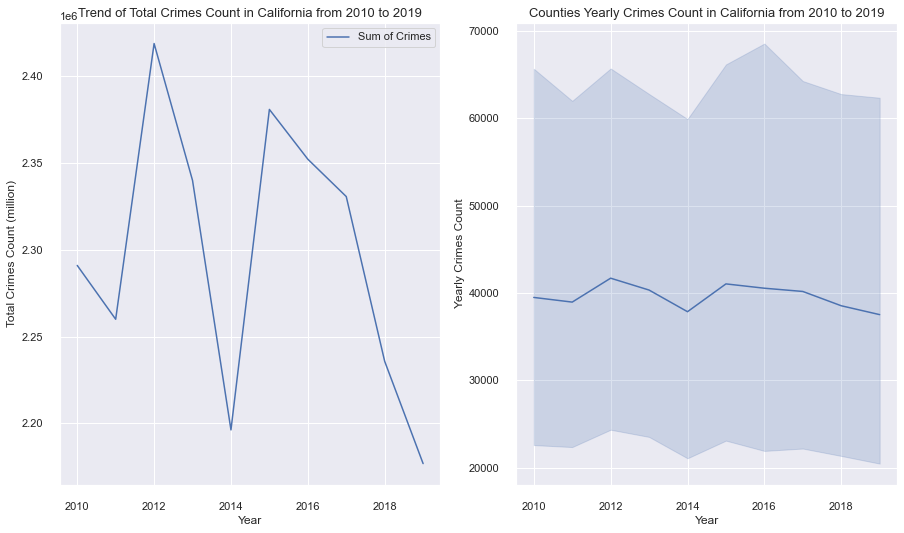

In [31]:
fig, (crimevisual, crimevisual2) = plt.subplots(ncols = 2, sharey = False)
sns.lineplot(data = crime.groupby('Year').sum(), ax = crimevisual)
crimevisual.set_title('Trend of Total Crimes Count in California from 2010 to 2019', size = 13)
crimevisual.set_ylabel('Total Crimes Count (million)')
sns.lineplot(data = crime, x = 'Year', y = 'Sum of Crimes', ax = crimevisual2)
crimevisual2.set_title('Counties Yearly Crimes Count in California from 2010 to 2019', size = 13)
crimevisual2.set_ylabel('Yearly Crimes Count')
plt.show()

Here we can see that the general trend of the total crimes count reported yearly in california is decresing from 2010-2019 with a steep drop in 2014(Figure left). When plotting counties' yearly report(Figure right), we can see that the overall trend for county based crimes count is slightly decreasing as well.

## Population Density Dataset Exploratory Data Analysis and Visualization

The population density is the total number of individuals living within a specific location. We were able to find the population density by taking the total population of each county in California and dividing it by the total square miles per county. Since the population density refers to the total number of individuals living within a specific location, we would expect a clear trend in our data. However, it would be useful to visualize the general trend of the total population density within our timeframed data gathered from 2010-2019. To do this, we will sum our population density by each year and generate a lineplot illustrating the years on the x-axis and population density on the y-axis.

In [32]:
population_density_sum = population_density.groupby('Year').sum()
population_density_sum.head()

,Population Density
Year,
2010,38430
2011,38849
2012,39325
2013,39762
2014,40216


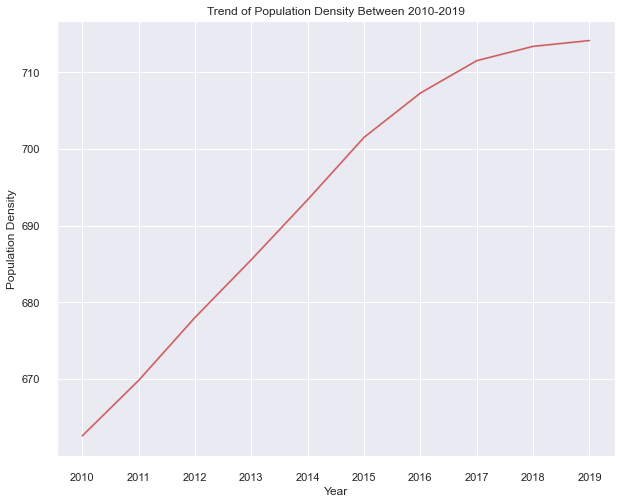

In [20]:
population_density_sum = population_density.copy()
population_density_sum['Population Density'] = population_density.groupby(["Year"])["Population Density"].transform(np.mean)

sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(data = population_density_sum, x = 'Year', y = 'Population Density', color = 'indianred').set(title = 'Trend of Population Density Between 2010-2019')
plt.show()


In our generated graph above, we can see the trend of population density between our gathered years of 2010 to 2019 to have a constant increase as the years progress. 

In order to get a better idea of all of our gathered data we chose to plot the frequency of all population density across all counties gathered.

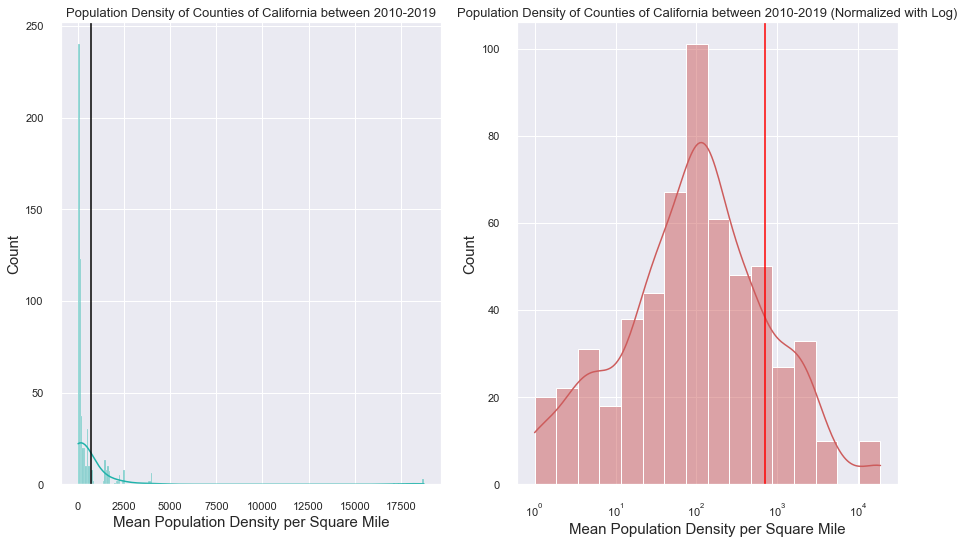

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.style.use('seaborn-poster')
sns.set(rc={'figure.figsize':(15,8.5)})

sns.histplot(data = population_density, x = 'Population Density', ax=ax1, kde=True, color='lightseagreen')
ax1.set_xlabel('Mean Population Density per Square Mile', fontsize = 15)
ax1.set_ylabel('Count', fontsize = 15)
ax1.set_title('Population Density of Counties of California between 2010-2019', fontsize = 13)
ax1.axvline(x = population_density["Population Density"].mean(), color = 'black')

sns.histplot(data = population_density, x='Population Density', ax=ax2, kde=True, color='indianred', log_scale=True)
ax2.set_xlabel('Mean Population Density per Square Mile', fontsize = 15)
ax2.set_ylabel('Count', fontsize = 15)
ax2.set_title('Population Density of Counties of California between 2010-2019 (Normalized with Log)', fontsize = 13)
ax2.axvline(x = population_density["Population Density"].mean(), color = 'red')

In our generated graphs above, on the left we can see the frequency of population density in california having a right skewed distribution. Whereas, there is a normal skewed distribution in our log scale generated graph on the right.

To get a better picture, we generated a boxplot of the population density.

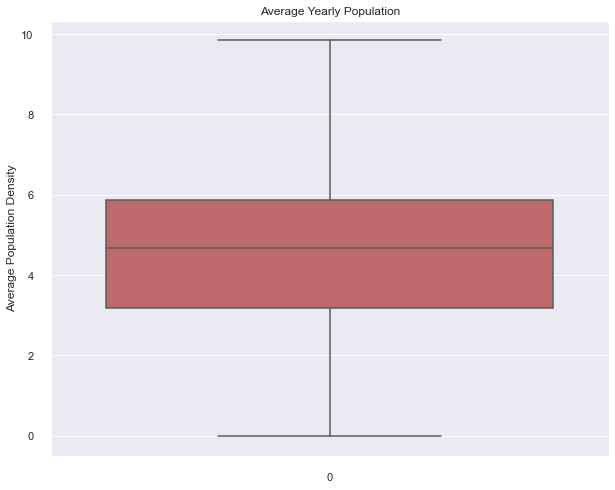

In [28]:
# Plot of the Population Density Boxplot

sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(data=np.log(population_density['Population Density']), color = 'indianred').set(title='Average Yearly Population', ylabel='Average Population Density')
plt.show()

When looking at our population density boxplot we can see that there are no outliers and this could be due to the constant increase in population over the course of our ten year dataset (2010-2019).

# Correlation

In this part, we will be plotting the four datasets which represent four different independent variables(police, weather, income, population density) against our crime dataset respectively to find the relationship between the independent variables and the dependent variables. In order to display the correlation as well as the strength of correlation of our quantitatve variables, we will be mostly using scatterplots.

## Police & Crimes

We begains by merging the data of crimes and number of police on county name and year. We will make yearly scatterplots of numbers of crimes againt number of total officers in California as well as a overall plot generalizing the relationship of crimes and police from 2010 to 2019.

In [36]:
#First mergeing the police and crime data
crime_police = police.merge(crime)
crime_police = crime_police.assign(log = np.log(crime_police['Total_Officers']))
crime_police

,County,Total_Officers,Year,Sum of Crimes,log
0,alameda,1635,2010,121582,7.399398
1,butte,258,2010,13404,5.552960
2,contra costa,952,2010,70012,6.858565
3,el dorado,346,2010,6530,5.846439
4,fresno,891,2010,88748,6.792344
...,...,...,...,...,...
575,sierra,12,2019,64,2.484907
576,siskiyou,103,2019,1634,4.634729
577,tehama,107,2019,3758,4.672829
578,trinity,50,2019,596,3.912023


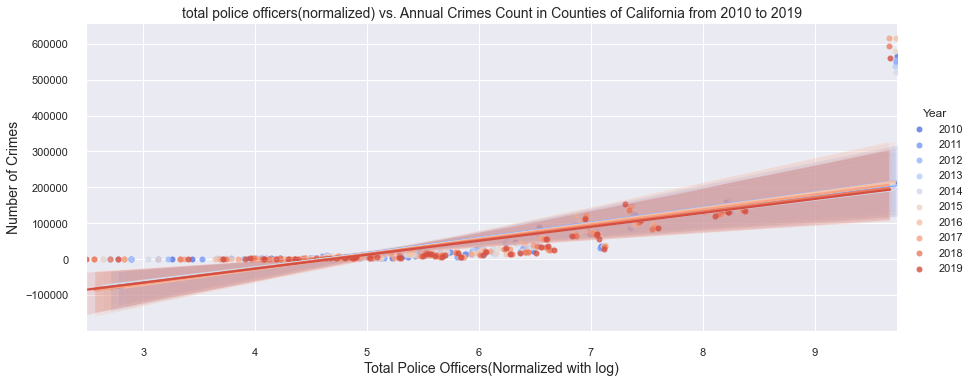

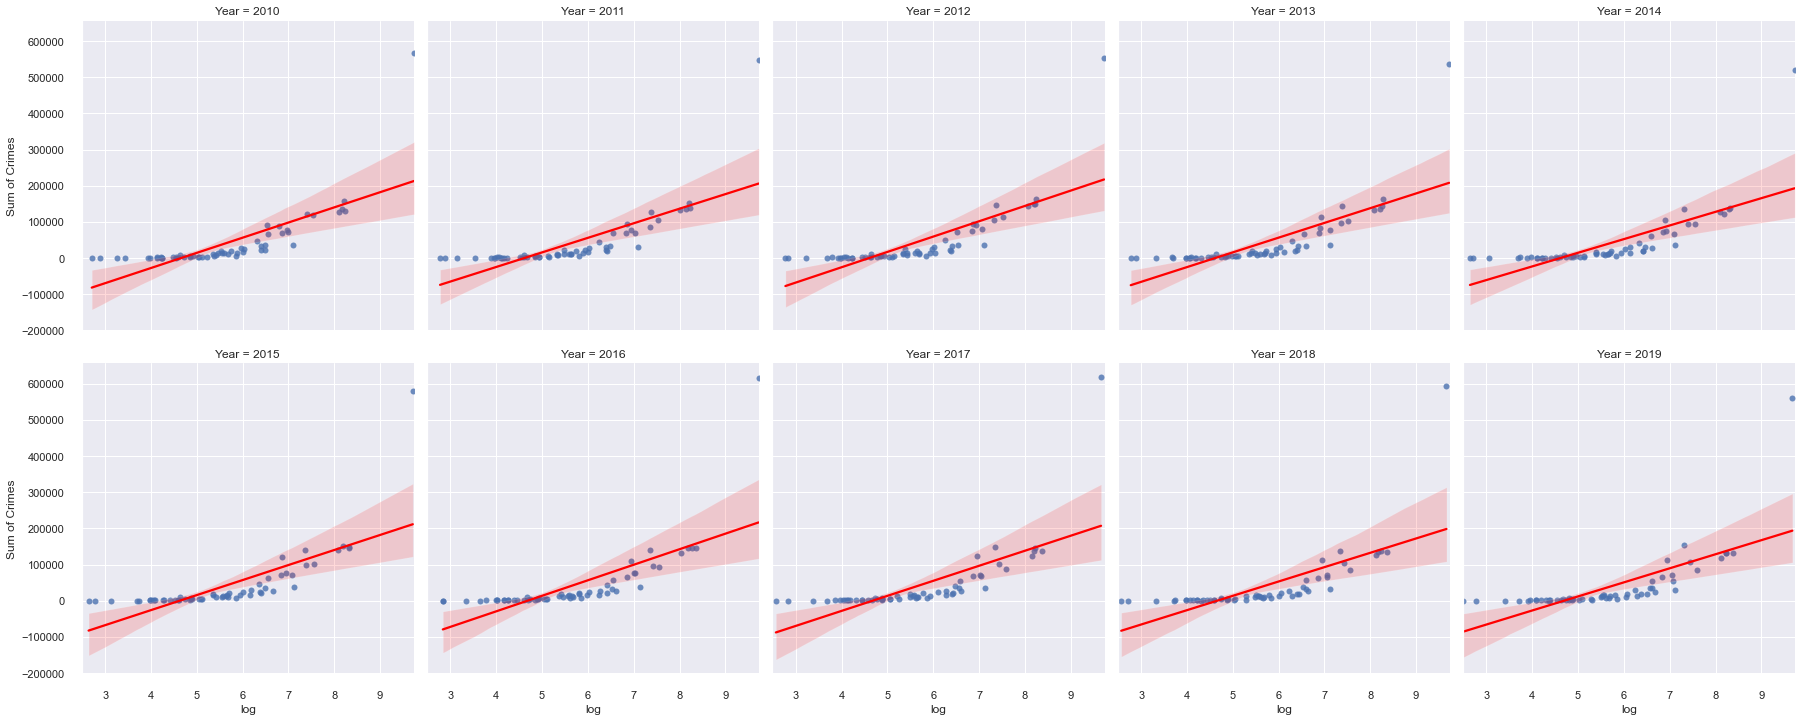

In [37]:
sns.lmplot(data=crime_police, 
           x="log", 
           y="Sum of Crimes", 
           hue = 'Year', 
           palette = sns.color_palette("coolwarm", 10),
           aspect = 2.5
)
plt.title('total police officers(normalized) vs. Annual Crimes Count in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Total Police Officers(Normalized with log)', size = 14)
plt.ylabel('Number of Crimes', size = 14)


sns.lmplot(data=crime_police, 
           x="log", 
           y="Sum of Crimes", 
           col="Year", 
           col_wrap=5, 
           line_kws={'color': 'red'},
)

plt.show()

The first plot is generated to see the correlation between log( ) of totle officers and number of crimes in <b> each </b> years. As shown in the plots, a reletive strong positive correlation could be observed, meaning that more police correlates with more crimes committed. An oitlier is obeserved on the right-top corner of the graph. This is due to the fact that Los Angeles has more police officers and more crime is occuring in Los Angeles county. We could also obeserved that the slope of all the best fit lines did not vary much, implying that the more-police-more-crime is relatively steady throughout these 10 years.  
The second set of the plots is the break down of the first gerenal plot.

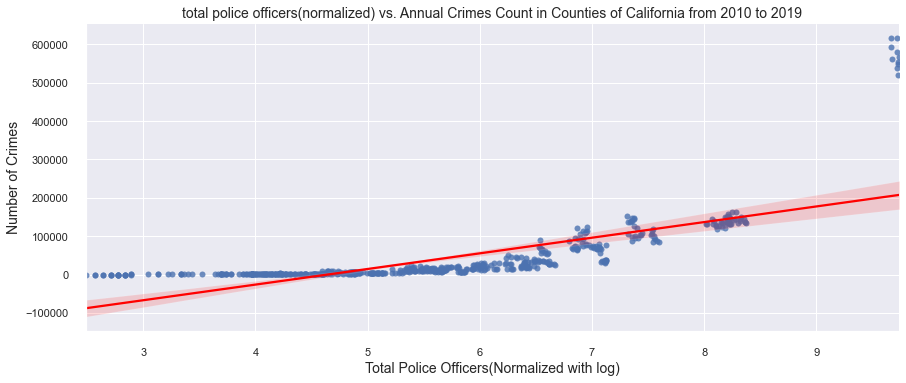

In [38]:
sns.lmplot(data=crime_police, 
           x="log", 
           y="Sum of Crimes", 
           line_kws={'color': 'red'},
           aspect = 2.5)
plt.title('total police officers(normalized) vs. Annual Crimes Count in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Total Police Officers(Normalized with log)', size = 14)
plt.ylabel('Number of Crimes', size = 14)
plt.show()

This plot above is generate to see the correlation between log( ) of total officers and number of crimes in <b>all</b> 10 years. Similarly, a positive correlation is presented but stronger as the margin of error (indicated by the shaded area next to the best-fit line) is smaller. This means that when looking at the general data of the number of police and crimes of all counties, the more-police-more-crime correlation is more steady. There is also outliers in this plot, which is also due to the fact of the massive amout of police officers as well as number of crimes in Los Angeles county.

## Weather & Crimes

We will now merge our weather dataset with the crime dataset in order to find their relationship, luckily our two datasets perfectly merged together with no null values, meaning our county names are consistent.

In [39]:
weather_crime = weather.merge(crime, how = 'left')
weather_crime.isnull().sum()

Year                 0
County               0
Avg_Temperature      0
Avg_Precipitation    0
Sum of Crimes        0
dtype: int64

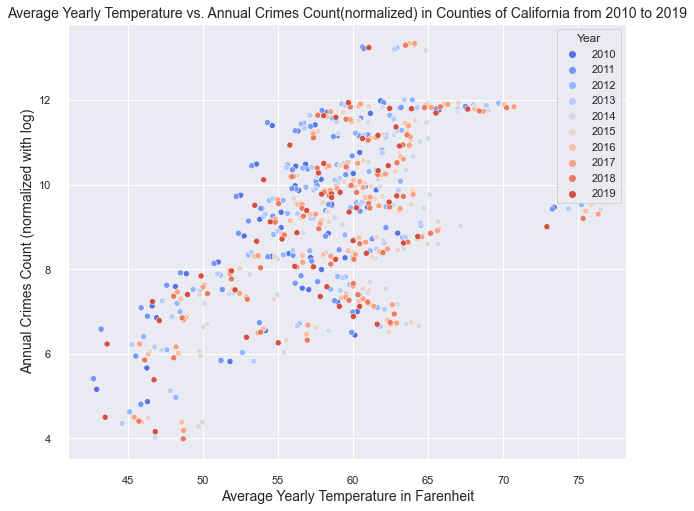

In [40]:
weather_crime['logcrime'] = np.log(weather_crime['Sum of Crimes'])
sns.scatterplot(data = weather_crime, 
                x = 'Avg_Temperature', 
                y = 'logcrime', 
                hue = 'Year', 
                palette = sns.color_palette("coolwarm", 10))
plt.title('Average Yearly Temperature vs. Annual Crimes Count(normalized) in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Average Yearly Temperature in Farenheit', size = 14)
plt.ylabel('Annual Crimes Count (normalized with log)', size = 14)
plt.show()

From this graph we can see that the the annual crimes count(logged) is somehow linearly correlated with average yearly temperature with a positive slope, meaning that warmer temperature correlates with more crimes committed. However, observing that red dots(data from 2019) are the blue dots(data from 2010) horizontally shifted to the right further implies that the crime count didn't increase nor decrease while the average yearly temperature increased, hence we have to admit that even if there is a correlation, the correlation coefficient between temperature and crimes count wouldn't be so strong.  
Let's further explore the correlation of crimes and temperature by drawing yearly best fitted lines.

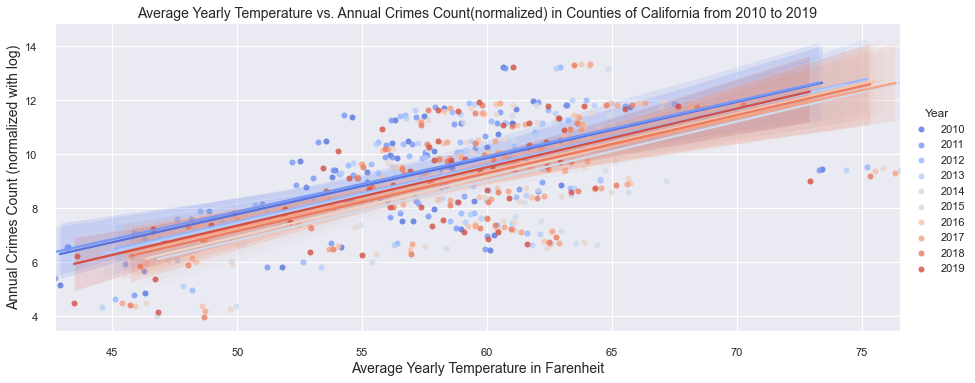

In [41]:
sns.lmplot(data = weather_crime, 
                x = 'Avg_Temperature', 
                y = 'logcrime', 
                hue = 'Year', 
                palette = sns.color_palette("coolwarm", 10),
          aspect = 2.5)
plt.title('Average Yearly Temperature vs. Annual Crimes Count(normalized) in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Average Yearly Temperature in Farenheit', size = 14)
plt.ylabel('Annual Crimes Count (normalized with log)', size = 14)
plt.show()

We can see that best fitted lines drawn yearly(blue ~ red = 2010 ~ 2019) all have the same slope while the y intercept lowered. This can be explained by the total number of crimes decreased from 2010 to 2019 in California.   
Similarly, Let's visualize the average yearly precipitation against crimes using the same approach.

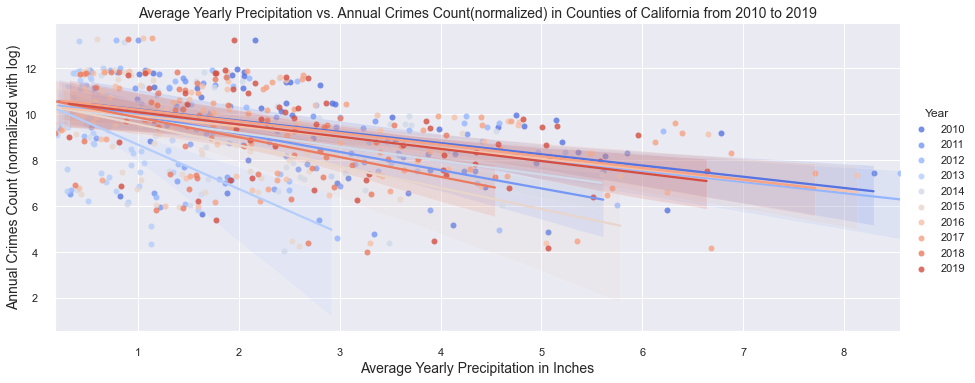

In [42]:
sns.lmplot(data = weather_crime, 
                x = 'Avg_Precipitation', 
                y = 'logcrime', 
                hue = 'Year', 
                palette = sns.color_palette("coolwarm", 10),
          aspect = 2.5)
plt.title('Average Yearly Precipitation vs. Annual Crimes Count(normalized) in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Average Yearly Precipitation in Inches', size = 14)
plt.ylabel('Annual Crimes Count (normalized with log)', size = 14)
plt.show()

Unlike temperature, average yearly precipitation shows a negatvie correlation with annual crimes count. In other words, heavy rainfalls correlates with less crimes count which is reasonable. Futhermore, yearly best fitted lines do not overlap much which implies that the correlation coefficient of precipitation and crime count is weaker than that of temperature and crime count.

## Income & Crimes

To compare income and crimes, we need to combine the datasets. 

In [43]:
income_crime = income.merge(crime, how = 'left')
income_crime = income_crime.dropna()
income_crime = income_crime.assign(log = np.log(income_crime['Mean Income Per Capita']))
income_crime

,County,Mean Income Per Capita,Year,Sum of Crimes,log
0,alameda,32398,2010,121582.0,10.385852
1,butte,22263,2010,13404.0,10.010681
2,contra costa,34977,2010,70012.0,10.462446
3,el dorado,33111,2010,6530.0,10.407621
4,fresno,19083,2010,88748.0,9.856553
...,...,...,...,...,...
394,stanislaus,26686,2019,34364.0,10.191894
395,sutter,30411,2019,5530.0,10.322560
396,tehama,26932,2019,3758.0,10.201070
397,tulare,23096,2019,24634.0,10.047415


Here, we can see the relationship between income and arrests. Our graphs show that there is a consistent slightly positive correlation between arrests and income each year. This consitency implies that this correlation of high-crime-high-income is consistent throuhgout time. While this graph does not show correlations within counties, it suggests that we can expect to see wealthier counties have higher crime rates than lower income ones. 

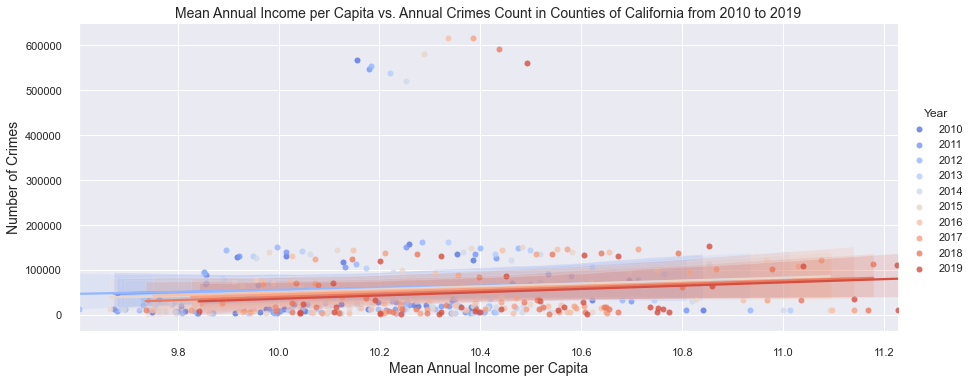

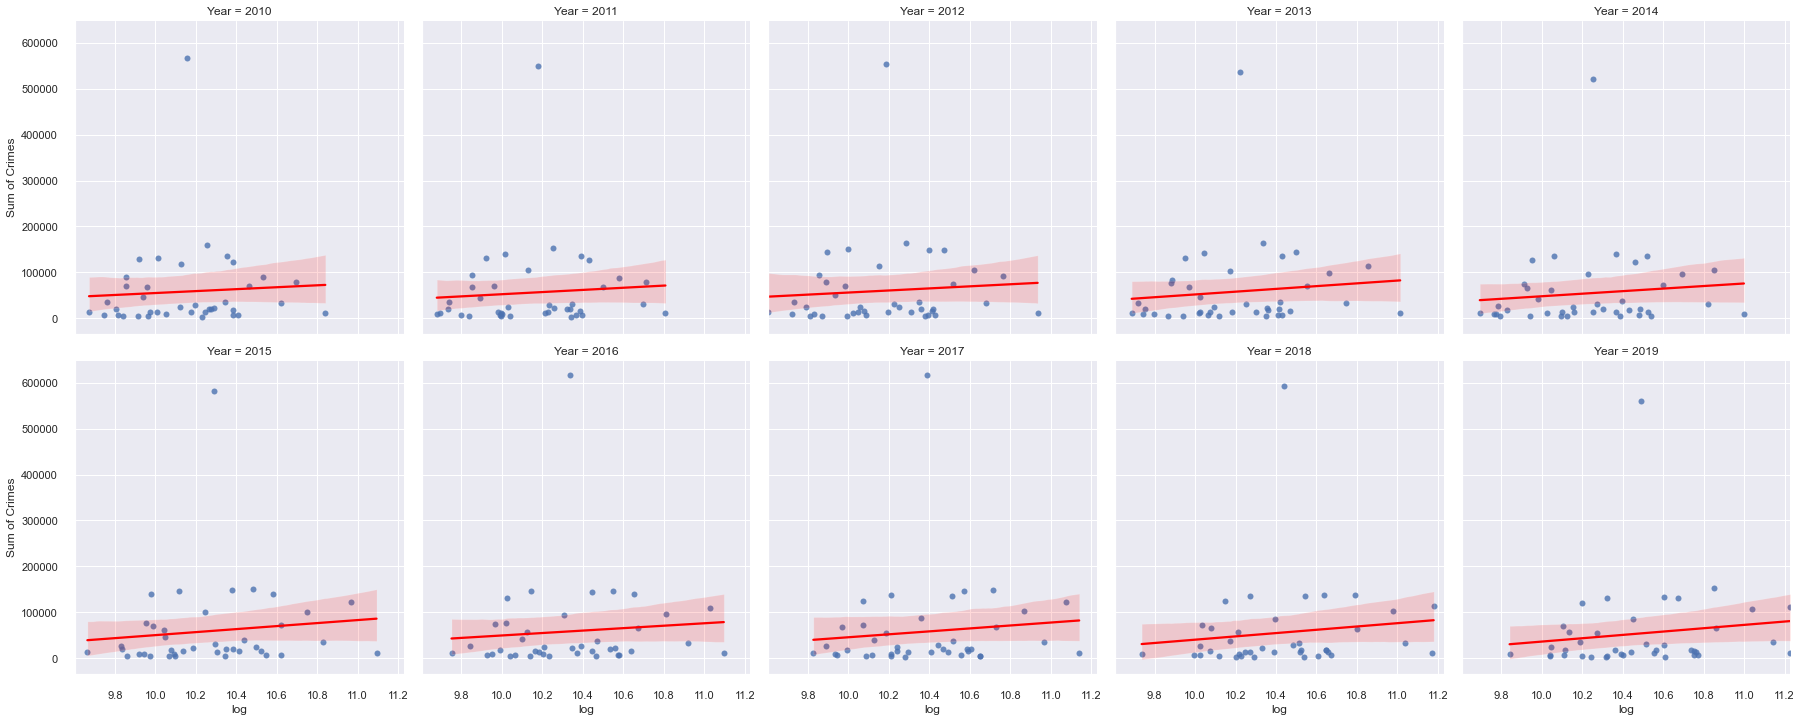

In [44]:
sns.lmplot(data=income_crime, 
           x="log", 
           y="Sum of Crimes", 
           hue = 'Year', 
           palette = sns.color_palette("coolwarm", 10),
           aspect = 2.5
)
plt.title('Mean Annual Income per Capita vs. Annual Crimes Count in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Mean Annual Income per Capita', size = 14)
plt.ylabel('Number of Crimes', size = 14)


sns.lmplot(data=income_crime, 
           x="log", 
           y="Sum of Crimes", 
           col="Year", 
           col_wrap=5, 
           line_kws={'color': 'red'},
)

plt.show()

## Population Density & Crimes

In order to compare the population density and crimes we first need to merge the datasets.

In [45]:
#Merging Population Density and Crime
population_density_crime = population_density.assign(Year = population_density['Year'].apply(int))
population_density_crime = population_density_crime.merge(crime)
population_density_crime = population_density_crime.assign(Log = np.log(population_density_crime['Population Density']))
population_density_crime

,County,Year,Population Density,Sum of Crimes,Log
0,alameda,2010,2047,121582,7.624131
1,alameda,2011,2071,126888,7.635787
2,alameda,2012,2102,148058,7.650645
3,alameda,2013,2137,143744,7.667158
4,alameda,2014,2175,135952,7.684784
...,...,...,...,...,...
575,yuba,2015,117,4662,4.762174
576,yuba,2016,118,4524,4.770685
577,yuba,2017,121,4794,4.795791
578,yuba,2018,122,4394,4.804021


In order to show the correlation between the population density and sum of crimes we created a graph illustrating the best fitted lines.

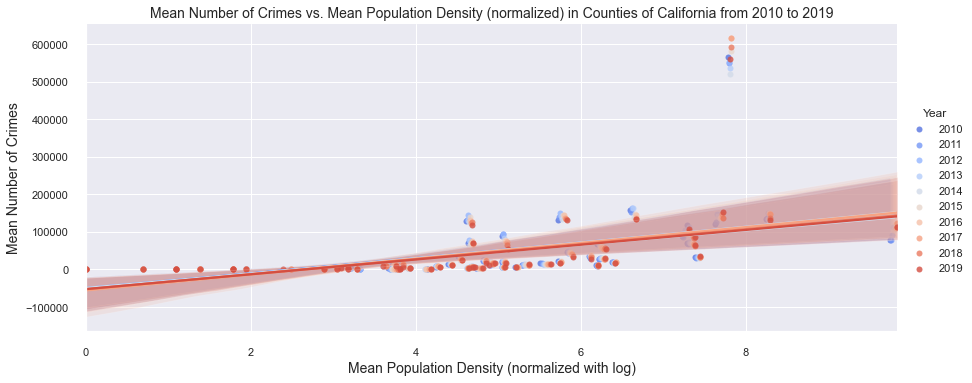

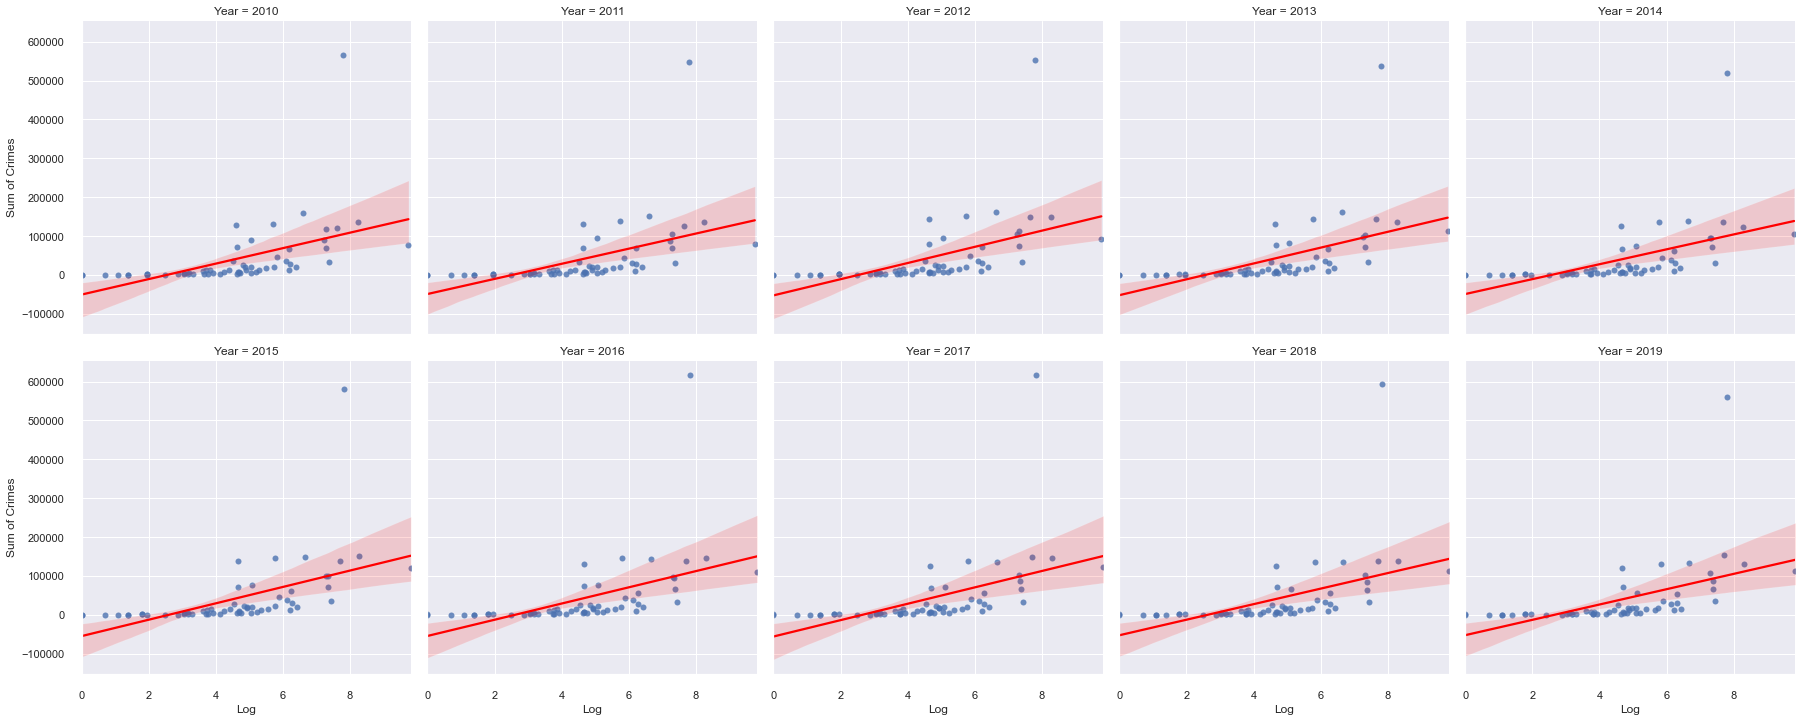

In [46]:
sns.lmplot(data = population_density_crime, 
           x = "Log", 
           y = "Sum of Crimes", 
           hue = 'Year', 
           palette = sns.color_palette("coolwarm", 10),
           aspect = 2.5
)
plt.title('Mean Number of Crimes vs. Mean Population Density (normalized) in Counties of California from 2010 to 2019', size = 14)
plt.xlabel('Mean Population Density (normalized with log)', size = 14)
plt.ylabel('Mean Number of Crimes', size = 14)


sns.lmplot(data = population_density_crime, 
           x = "Log", 
           y = "Sum of Crimes", 
           col = "Year", 
           col_wrap = 5, 
           line_kws = {'color': 'red'},
)

plt.show()

When looking at our best fitted line between the yearly population density and the annual crime count we can see that all of the years between our gathered data from 2010 to 2019 have a very similar slope. This can be explained due to the increasing normalized trend in population density.